# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('./data/train_macro3.csv', index_col=0)
df_test_macro = pd.read_csv('./data/test_macro3.csv', index_col=0)

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     111.9
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:30:46   Log-Likelihood:                -19210.
No. Observations:               30404   AIC:                         3.882e+04
Df Residuals:                   30206   BIC:                         4.046e+04
Df Model:                         197                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0545      0.010      5.291      0.000       0.034       0.075
C(_culture_objects_top_25)[T.yes]                          0.0094      0.026      0.358      0.721      -0.042       0.061
C(_railroad_terminal_raion)[T.yes]                         0.0264      0.035      0.746      0.455      -0.043       0.096
C(_water_1line)[T.yes]                                     0.0021      0.013      0.165      0.869      -0.023       0.028
C(_nuclear_reactor_raion)[T.yes]                           0.0960      0.032      2.959      0.003       0.032       0.160
C(_big_road1_1line)[T.yes]                                -0.0414      0.020     -2.029      0.042      -0.081      -0.001
C(_railroad_1line)[T.yes]                                 -0.0887      0.020     -4.411      0.000      -0.128      -0.049
C(_product_type)[T.OwnerOccupier]                          0.1455      0.013     11.284      0.000       0.120       0.171
C(_thermal_power_plant_raion)[T.yes]                      -0.0440      0.026     -1.725      0.085      -0.094       0.006
C(_incineration_raion)[T.yes]                              0.0010      0.036      0.028      0.977      -0.069       0.071
C(_big_market_raion)[T.yes]                                0.0903      0.025      3.584      0.000       0.041       0.140
C(_detention_facility_raion)[T.yes]                        0.0431      0.021      2.067      0.039       0.002       0.084
C(_ecology)[T.good]                                       -0.0009      0.028     -0.031      0.975      -0.056       0.054
C(_ecology)[T.no data]                                     0.0724      0.057      1.259      0.208      -0.040       0.185
C(_ecology)[T.poor]                                       -0.0259      0.020     -1.276      0.202      -0.066       0.014
C(_ecology)[T.satisfactory]                               -0.0392      0.028     -1.403      0.161      -0.094       0.016
C(_oil_chemistry_raion)[T.yes]                            -0.0197      0.050     -0.393      0.694      -0.118       0.078
C(_radiation_raion)[T.yes]                                -0.0411      0.013     -3.075      0.002      -0.067      -0.015
np.log(_usdrub)                                            0.0151      0.038      0.398      0.691      -0.059       0.089
np.log(_full_sq)                                           0.1349      0.129      1.047      0.295      -0.118       0.388
np.log(_life_sq)                                           0.0636      0.029      2.177      0.030       0.006       0.121
_floor                                                     0.0088      0.002      5.653      0.000       0.006       0.012
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     75.58
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:32:24   Log-Likelihood:                -19160.
No. Observations:               30404   AIC:                         3.891e+04
Df Residuals:                   30110   BIC:                         4.135e+04
Df Model:                         293                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5561      0.026    591.072      0.000      15.505      15.608
C(_culture_objects_top_25)[T.yes]                                 0.0046      0.026      0.176      0.860      -0.047       0.056
C(_railroad_terminal_raion)[T.yes]                                0.0370      0.036      1.037      0.300      -0.033       0.107
C(_water_1line)[T.yes]                                           -0.0005      0.013     -0.041      0.967      -0.026       0.025
C(_nuclear_reactor_raion)[T.yes]                                  0.0963      0.033      2.932      0.003       0.032       0.161
C(_big_road1_1line)[T.yes]                                       -0.0362      0.020     -1.794      0.073      -0.076       0.003
C(_railroad_1line)[T.yes]                                        -0.0927      0.020     -4.608      0.000      -0.132      -0.053
C(_product_type)[T.OwnerOccupier]                                 0.1468      0.013     11.347      0.000       0.121       0.172
C(_thermal_power_plant_raion)[T.yes]                             -0.0486      0.025     -1.905      0.057      -0.099       0.001
C(_incineration_raion)[T.yes]                                     0.0098      0.037      0.265      0.791      -0.063       0.082
C(_big_market_raion)[T.yes]                                       0.0749      0.026      2.920      0.004       0.025       0.125
C(_detention_facility_raion)[T.yes]                               0.0427      0.021      2.045      0.041       0.002       0.084
C(_ecology)[T.good]                                              -0.0057      0.028     -0.203      0.839      -0.061       0.049
C(_ecology)[T.no data]                                            0.0805      0.058      1.384      0.166      -0.033       0.195
C(_ecology)[T.poor]                                              -0.0274      0.020     -1.358      0.174      -0.067       0.012
C(_ecology)[T.satisfactory]                                      -0.0354      0.028     -1.274      0.203      -0.090       0.019
C(_oil_chemistry_raion)[T.yes]                                   -0.0269      0.051     -0.529      0.597      -0.127       0.073
C(_radiation_raion)[T.yes]                                       -0.0402      0.013     -3.012      0.003      -0.066      -0.014
scale(np.log(_usdrub))                                            0.9404      0.107      8.754      0.000       0.730       1.151
scale(np.log(_full_sq))                                           0.0227      0.045      0.510      0.610      -0.065       0.110
scale(np.log(_life_sq))                                           0.0312      0.018      1.74

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_culture_objects_top_25),0.006453,1.0,0.030949,8.603550e-01
C(_railroad_terminal_raion),0.224242,1.0,1.075501,2.997145e-01
C(_water_1line),0.000352,1.0,0.001687,9.672384e-01
C(_nuclear_reactor_raion),1.792674,1.0,8.597943,3.367961e-03
C(_big_road1_1line),0.671169,1.0,3.219031,7.279672e-02
C(_railroad_1line),4.426300,1.0,21.229229,4.091712e-06
C(_product_type),26.844653,1.0,128.751154,8.837397e-30
C(_thermal_power_plant_raion),0.756340,1.0,3.627523,5.684086e-02
C(_incineration_raion),0.014680,1.0,0.070406,7.907487e-01
C(_big_market_raion),1.778045,1.0,8.527782,3.500251e-03



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     341.0
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:37:19   Log-Likelihood:                -19603.
No. Observations:               30404   AIC:                         3.933e+04
Df Residuals:                   30342   BIC:                         3.985e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.5660      0.006   2678.635      0.000      15.555      15.577
C(_railroad_1line)[T.yes]                             -0.1395      0.017     -8.092      0.000      -0.173      -0.106
C(_product_type)[T.OwnerOccupier]                      0.1581      0.010     15.835      0.000       0.139       0.178
C(_big_market_raion)[T.yes]                            0.0848      0.014      6.105      0.000       0.058       0.112
C(_detention_facility_raion)[T.yes]                    0.0297      0.014      2.195      0.028       0.003       0.056
C(_radiation_raion)[T.yes]                            -0.0502      0.008     -6.517      0.000      -0.065      -0.035
scale(np.log(_usdrub))                                 0.9585      0.105      9.097      0.000       0.752       1.165
scale(_floor)                                          0.0534      0.008      6.526      0.000       0.037       0.069
scale(_state)                                         -0.1081      0.016     -6.709      0.000      -0.140      -0.077
scale(np.log(_area_m))                                 0.6887      0.123      5.596      0.000       0.447       0.930
scale(_preschool_education_centers_raion)             -0.0331      0.012     -2.808      0.005      -0.056      -0.010
scale(_school_education_centers_raion)                 0.0959      0.017      5.645      0.000       0.063       0.129
scale(np.log(_university_top_20_raion))                0.0704      0.020      3.442      0.001       0.030       0.110
scale(np.log(_public_transport_station_min_walk))     -0.0172      0.004     -4.283      0.000      -0.025      -0.009
scale(np.log(_kremlin_km))                             0.1875      0.012     16.160      0.000       0.165       0.210
scale(np.log(_zd_vokzaly_avto_km))                     0.0796      0.015      5.381      0.000       0.051       0.109
scale(np.log(_nuclear_reactor_km))                    -0.0163      0.005     -3.041      0.002      -0.027      -0.006
scale(np.log(_power_transmission_line_km))             0.0215      0.005      4.278      0.000       0.012       0.031
scale(np.log(_market_shop_km))                        -0.0217      0.005     -4.249      0.000      -0.032      -0.012
scale(np.log(_workplaces_km))                         -0.0117      0.006     -2.069      0.039      -0.023      -0.001
scale(np.log(_additional_education_km))               -0.0269      0.004     -6.536      0.000      -0.035      -0.019
scale(np.log(_mosque_km))                              0.0417      0.007      5.689      0.000       0.027       0.056
scale(np.log(_leisure_count_1000))                     0.0413      0.009      4.493      0.000       0.023  

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     3500.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:38:16   Log-Likelihood:                 14580.
No. Observations:               26731   AIC:                        -2.904e+04
Df Residuals:                   26669   BIC:                        -2.853e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.7478      0.002   7893.091      0.000      15.744      15.752
C(_railroad_1line)[T.yes]                             -0.1540      0.006    -26.140      0.000      -0.166      -0.142
C(_product_type)[T.OwnerOccupier]                     -0.0507      0.003    -15.324      0.000      -0.057      -0.044
C(_big_market_raion)[T.yes]                            0.0478      0.005     10.468      0.000       0.039       0.057
C(_detention_facility_raion)[T.yes]                    0.0589      0.005     12.984      0.000       0.050       0.068
C(_radiation_raion)[T.yes]                            -0.0280      0.003    -10.937      0.000      -0.033      -0.023
scale(np.log(_usdrub))                                 0.6571      0.034     19.098      0.000       0.590       0.725
scale(_floor)                                          0.0622      0.003     22.074      0.000       0.057       0.068
scale(_state)                                         -0.0938      0.005    -17.847      0.000      -0.104      -0.084
scale(np.log(_area_m))                                 0.7470      0.042     17.982      0.000       0.666       0.828
scale(_preschool_education_centers_raion)             -0.0479      0.004    -12.015      0.000      -0.056      -0.040
scale(_school_education_centers_raion)                 0.1299      0.006     22.633      0.000       0.119       0.141
scale(np.log(_university_top_20_raion))                0.0030      0.007      0.419      0.675      -0.011       0.017
scale(np.log(_public_transport_station_min_walk))     -0.0178      0.001    -13.135      0.000      -0.020      -0.015
scale(np.log(_kremlin_km))                             0.1697      0.004     42.029      0.000       0.162       0.178
scale(np.log(_zd_vokzaly_avto_km))                     0.0612      0.006     10.581      0.000       0.050       0.073
scale(np.log(_nuclear_reactor_km))                    -0.0120      0.002     -6.714      0.000      -0.015      -0.008
scale(np.log(_power_transmission_line_km))             0.0232      0.002     13.706      0.000       0.020       0.027
scale(np.log(_market_shop_km))                        -0.0083      0.002     -4.848      0.000      -0.012      -0.005
scale(np.log(_workplaces_km))                         -0.0112      0.002     -5.810      0.000      -0.015      -0.007
scale(np.log(_additional_education_km))               -0.0013      0.001     -0.925      0.355      -0.004       0.001
scale(np.log(_mosque_km))                              0.0308      0.002     12.620      0.000       0.026       0.036
scale(np.log(_leisure_count_1000))                     0.0228      0.003      6.788      0.000       0.016  

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     5463.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:38:33   Log-Likelihood:                 16566.
No. Observations:               25092   AIC:                        -3.304e+04
Df Residuals:                   25048   BIC:                        -3.269e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.7632      0.002   9164.221      0.000      15.760      15.767
C(_railroad_1line)[T.yes]                             -0.1595      0.006    -27.034      0.000      -0.171      -0.148
C(_product_type)[T.OwnerOccupier]                     -0.0793      0.003    -25.860      0.000      -0.085      -0.073
C(_radiation_raion)[T.yes]                            -0.0316      0.002    -13.828      0.000      -0.036      -0.027
scale(np.log(_usdrub))                                 0.0431      0.001     51.059      0.000       0.041       0.045
scale(_floor)                                          0.0627      0.003     23.803      0.000       0.058       0.068
scale(_state)                                         -0.1301      0.005    -27.153      0.000      -0.140      -0.121
scale(np.log(_area_m))                                 0.0023      0.002      1.454      0.146      -0.001       0.005
scale(_school_education_centers_raion)                 0.0810      0.004     22.612      0.000       0.074       0.088
scale(np.log(_university_top_20_raion))                0.0037      0.001      3.244      0.001       0.001       0.006
scale(np.log(_public_transport_station_min_walk))     -0.0221      0.001    -18.328      0.000      -0.024      -0.020
scale(np.log(_zd_vokzaly_avto_km))                    -0.0169      0.005     -3.168      0.002      -0.027      -0.006
scale(np.log(_nuclear_reactor_km))                    -0.0095      0.001     -6.673      0.000      -0.012      -0.007
scale(np.log(_power_transmission_line_km))             0.0248      0.001     17.838      0.000       0.022       0.027
scale(np.log(_additional_education_km))                0.0125      0.001     10.865      0.000       0.010       0.015
scale(np.log(_mosque_km))                              0.0374      0.002     17.767      0.000       0.033       0.041
scale(np.log(_leisure_count_1000))                    -0.0471      0.002    -18.941      0.000      -0.052      -0.042
scale(np.log(_mosque_count_1500))                      0.0139      0.001     12.790      0.000       0.012       0.016
scale(np.log(_trc_count_2000))                         0.0252      0.004      7.094      0.000       0.018       0.032
scale(np.log(_sport_count_2000))                       0.0346      0.002     16.897      0.000       0.031       0.039
scale(np.log(_market_count_2000))                   1.598e-05      0.001      0.014      0.989      -0.002       0.002
scale(np.log(_mosque_count_5000))                      0.0343      0.002     21.801      0.000       0.031       0.037
scale(np.log(_leisure_count_5000))                    -0.0070      0.002     -3.525      0.000      -0.011  

# 5. Diagnosis of Regression
## Residual Normality Test

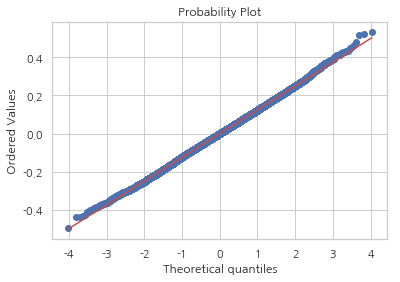

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  6.402
P-value     :  0.041


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

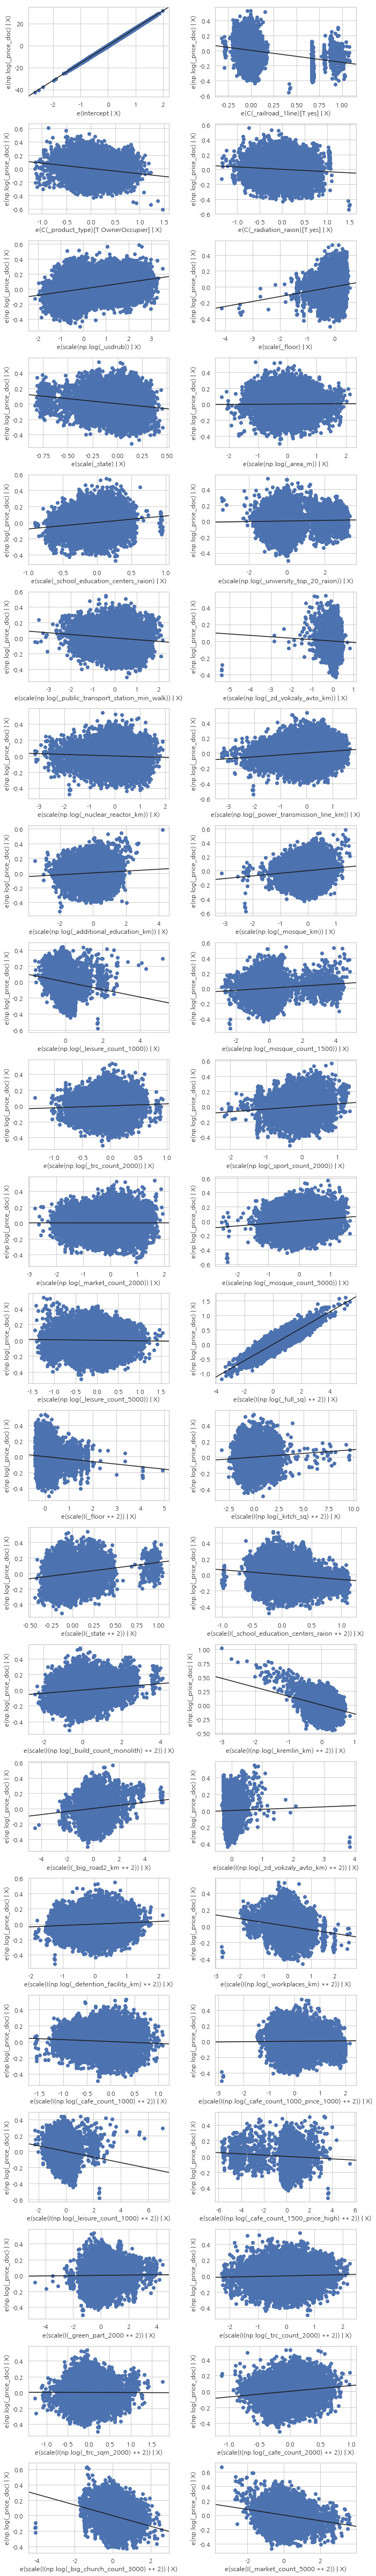

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.38221959804988215

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  2.,  1.,  2.,  1.,
         1.,  0.,  3.,  5.,  1.,  0.,  5.,  5.,  5.,  4.,  6.,  3.,  9.,
         9., 14., 11.,  6., 16., 15.,  8., 14., 18., 19., 27., 25., 28.,
        17., 21., 31., 28., 31., 20., 29., 35., 28., 39., 33., 36., 28.,
        36., 25., 31., 28., 31., 27., 17., 25., 16., 20., 20., 16., 10.,
        13.,  9., 10.,  4.,  7.,  2.,  2.,  2.,  2.]),
 array([-0.86230218, -0.84508509, -0.827868  , -0.81065091, -0.79343382,
        -0.77621673, -0.75899963, -0.74178254, -0.72456545, -0.70734836,
        -0.69013127, -0.67291418, -0.65569709, -0.63848   , -0.62126291,
        -0.60404581, -0.58682872, -0.56961163, -0.55239454, -0.53517745,
        -0.51796036, -0.50074327, -0.48352618, -0.46630909, -0.449092  ,
        -0.4318749 , -0.41465781, -0.39744072, -0.38022363, -0.363006

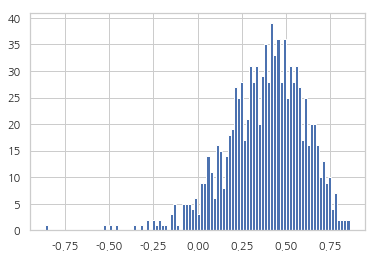

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('./data/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

0.39643